# Computer Vision Project - Rookie OCR

#### Pre-Requisite: Tesseract OCR
Installation Steps:
- Link -> [Tesseract OCR for Windows](https://github.com/tesseract-ocr/tesseract/releases/download/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe)
- Install Tesseract OCR on your machine
- Add the path of tesseract.exe to the environment variable (PATH)

**Note**: Its Recommended to run this .ipynb file from a virtual environment

In [ ]:
!pip install pytesseract
!pip install matplotlib 
!pip install opencv-python
!pip install pandas

### Importing Common Libraries or Modules

In [29]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt

from src.utils import *

#### Configuring Py-Teseract
##### --oem 3 (OCR Engine Mode):
Tells Tesseract which OCR engine(s) to use:
- 0: Legacy engine only
- 1: Neural nets LSTM engine only
- 2: Legacy + LSTM combined
- 3: Default — automatically selects the best available (LSTM preferred)

##### --psm 6 (Page Segmentation Mode): 
Determines how Tesseract splits the image into text lines or blocks.
6: Assume a single uniform block of text (good for clean text regions)
Common modes include:
- 3: Fully automatic page segmentation
- 6: Single block of text
- 7: Treat image as a single text line
- 8: Treat as a single word
- 11: Sparse text (good for scattered text)

In [ ]:
custom_config = r' — oem 3 — psm 6'
!tesseract --version

### Importing Text Image as Input

In [30]:
img = cv2.imread("assets/text_img.jpeg", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

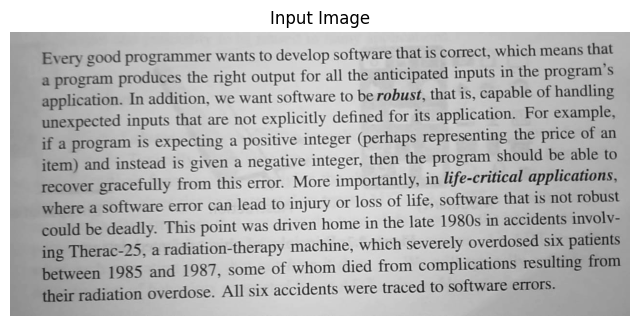

In [31]:
Plotter.PlotImage(img, title="Input Image")

### Filtering Input Image

- Unsharp Masking (USM)
- High-boost Filter


In [32]:
from src.image_processor.filters import *

In [33]:
unsharp_filter = FilterBuilder.Build(FilterType.UNSHARP_MASKING, strength=1.5)
unsharp_img =  unsharp_filter.Filter(img)

highboost_filter = FilterBuilder.Build(FilterType.HIGH_BOOST, A=1.7)
highboost_img = highboost_filter.Filter(img)

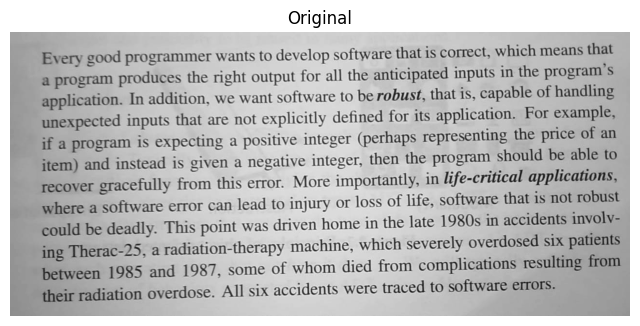

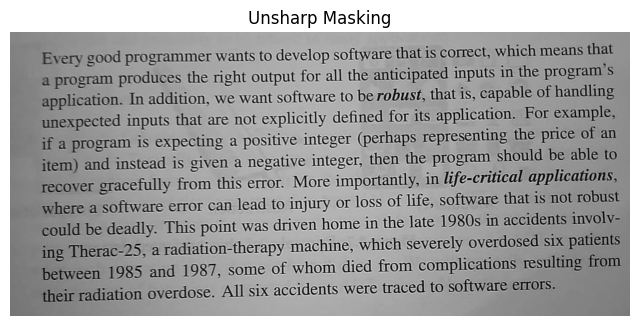

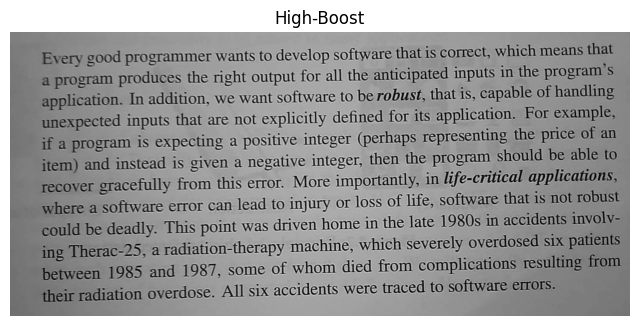

In [34]:
titles = ["Original", "Unsharp Masking", "High-Boost"]
images = [img, unsharp_img, highboost_img]

for i, (title, img) in enumerate(zip(titles, images)):
    Plotter.PlotImage(img, title=title)


**Note:** USM produces the best result, hence it is used in further steps.

In [35]:
filtered_img = unsharp_img

### Threasholding Filtered (Sharpened) Image

- Adaptive Gaussian Thresholding
- Otsu's Method
- Mode: Binary Inverted 

In [36]:
from src.image_processor.thresholding import *

In [37]:
adaptive_gaussian_thresh = ThresholdingBuilder.Build(
    ThresholdingType.ADAPTIVE_GAUSSIAN, 
    ThresholdingMode.BINARY_INV,
    sigma=1.0,
    block_size=11,
    C=2.0,
    max_value=255.0
)
adaptive_gaussian_thresh_img = adaptive_gaussian_thresh.ApplyThresholding(filtered_img)

otsu_thresh = ThresholdingBuilder.Build(
    ThresholdingType.OTSU,
    ThresholdingMode.BINARY_INV,
    max_value=255.0
)
otsu_thresh_img = otsu_thresh.ApplyThresholding(filtered_img)

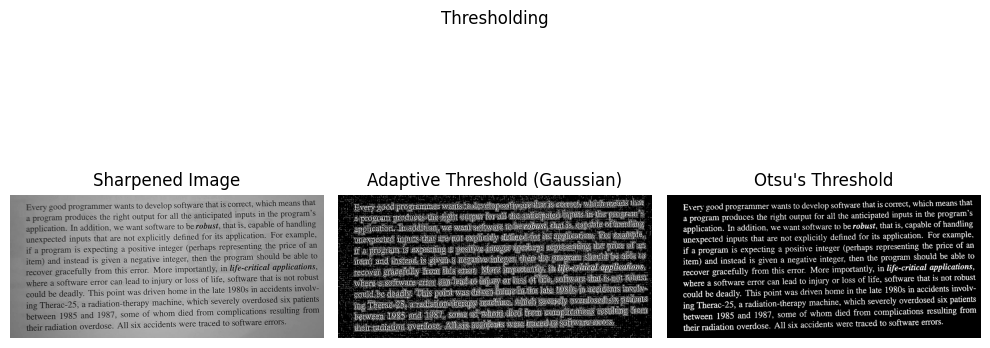

In [38]:
Plotter.PlotImages(
    [
        filtered_img,
        adaptive_gaussian_thresh_img,
        otsu_thresh_img,
    ],
    "Thresholding",
    ["Sharpened Image", "Adaptive Threshold (Gaussian)", "Otsu's Threshold"],
)

**Note:** Clearly, Otsu produces the best result here...

In [39]:
thresh_img = otsu_thresh_img

### Aligning the Thresholded Image

In [40]:
from src.utils import Aligner

In [41]:
aligned_img = Aligner.DeskewTextHorizontal(thresh_img)
save_img = False


Detected angle: -1.42 degrees


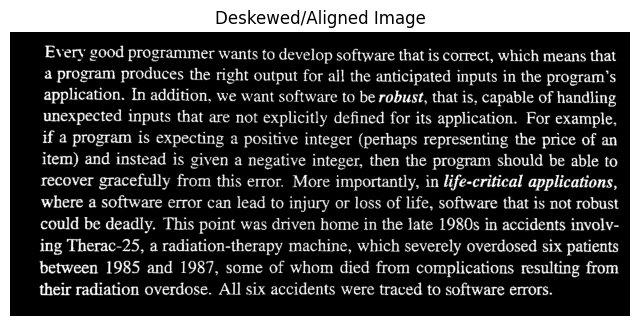

In [42]:
Plotter.PlotImage(aligned_img, title="Deskewed/Aligned Image")

In [43]:
if save_img:
    cv2.imwrite("./assets/test_deskewed.jpg", aligned_img)

### Segmentation of Aligned Image

- Line Segmentation (HPP)
- Word Segmentation (VPP)
- Character Segmentation (CCA)

In [44]:
from src.image_processor.segmentation import *

In [45]:
lines = SegmentationBuilder.Build(SegmentationType.HPP).Segment(aligned_img)
words = SegmentationBuilder.Build(SegmentationType.VPP).Segment(lines[0])
chars = SegmentationBuilder.Build(SegmentationType.CCA).Segment(words[0])

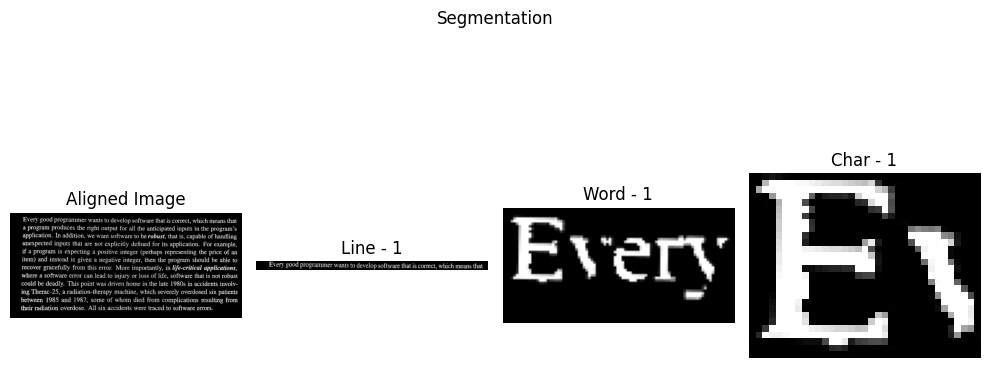

In [46]:
Plotter.PlotImages(
    [aligned_img, lines[0], words[0], chars[0]],
    "Segmentation",
    ["Aligned Image", "Line - 1", "Word - 1", "Char - 1"],
)

### PyTesseract

In [47]:
do_pytesseract = False

In [48]:
if do_pytesseract:
    for i in range(len(words)):
        print(pytesseract.image_to_string(words[i],config=custom_config))